# **Analysis of Marathon Data**

### By Netra Mittal 

## **Introduction**

Kernel Density Estimation gives us a way to create a smooth curve given a set of data. It serves as a continuous histogram that shows us the probability of observing an event given a condition. In other words, KDE computes the conditional probability of an event. This allows use to compute and predict probabilities using machine learning techniques as we will see in this project. 

The project analyzes marathon data and creates and compares a model based on the Bayes Theorem to one that utilizes the K-NN predictor. The project later analyzes the same dataset to build regression models while seeing how controlling for different factors can improve prediction outcomes. 

We can start by taking a look at the dataset:

In [ ]:
import numpy as np #importing modules
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("https://www.mth548.org/_static/kde_marathon_results/marathon_results.csv") #reading the dataframe
df["tot_minutes"] = pd.to_timedelta(df["Finish"]).dt.total_seconds()/60 #converting finish times to total minutes for easy calculations

In [ ]:
df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,129.283333
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,129.800000
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,130.366667
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,130.783333
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,130.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,64,F,USA,00:50:15,01:43:31,02:36:53,03:32:26,03:43:46,04:25:53,05:19:44,06:17:19,07:13:34,07:38:56,00:17:31,26594,12015,269,458.933333
26294,61,F,USA,00:48:36,01:39:39,02:39:13,03:35:58,03:47:55,04:32:44,05:31:58,06:28:56,07:26:19,07:51:30,00:17:59,26595,12016,270,471.500000
26295,66,F,USA,00:53:03,01:47:16,02:41:45,03:37:07,03:48:21,04:33:51,05:38:56,06:38:51,07:36:18,07:59:33,00:18:18,26596,12017,91,479.550000
26296,53,M,USA,00:49:04,01:40:12,02:33:31,03:31:41,03:43:35,04:29:20,05:31:11,06:33:35,07:35:38,08:00:37,00:18:20,26597,14580,2055,480.616667


We can first plot the probability of female based on finish time. This is also know as the Kernel Density Estimate or KDE which is a nonparametric representation of the probability density function of a random variable. The bandwidth and size of training data influence how smooth the plot is. Move the bandwidth and size of test data to see how:

In [ ]:
from sklearn.model_selection import train_test_split #import modules
from scipy.stats import gaussian_kde

def plot_f(bw, size):
  train_df, test_df = train_test_split(df, test_size=size/10, random_state=123)

  dfm = train_df[train_df["M/F"] == 'M']
  dff = train_df[train_df["M/F"] == 'F']
  kdem = gaussian_kde(dfm['tot_minutes'], bw_method=bw/10)
  kdef = gaussian_kde(dff['tot_minutes'], bw_method=bw/10)
  
  def p_f(time):
    pm = len(dfm)/len(train_df)
    pf = len(dff)/len(train_df)
    pf_given_mins = (kdef(time)*pf)/(kdef(time)*pf + kdem(time)*pm) 
    return pf_given_mins

  plt.figure(figsize=(8,6))
  plt.title('Probability a runner is female given time')
  plt.xlabel('Finishing Times')
  plt.ylabel('Probability')

  plt.plot(np.linspace(180, 360, 100), p_f(np.linspace(180, 360, 100)));

from ipywidgets import interact, fixed #import the interactive widgets
interact(plot_f, size=(1, 9, 1), bw=(1, 10, 1), show_kernels=True);

interactive(children=(IntSlider(value=5, description='bw', max=10, min=1), IntSlider(value=5, description='siz…

Based on this, we can observe that a higher size of testing data increases variation in our probability estimate. This makes sense as we'd observe larger errors with a small training set (evident from higher probabilities of observing 'female' corresponding to a smaller training size). Moreover, the larger the bandwidth, the smoother the curve, which could cost us some critical points to observe. We can see what the optimal bandwidth would be using methods like Maximum-Likelihood Estimation.

## **Part 1: Predicting if a runner was a male/female based on their finish times**


To compute whether a runner was female based on their finish time, we can take a look at the following: 

- Testing based on a range of training data sizes to check the improvement in accuracy with larger sets. 
- Using the Bayes Theorem and 1-dim KDE to compute probabilities of a runner being female given a finishing time. 
- Using different testing sizes to check how well the model predicts M/F. 

We can start by importing the required modules and splitting the data into training and testing sets for a range of sizes. Next, we'll compute KDE's for the training data for both men and women. Since KDE's give us the probability density function of observing that gender given their finish time, we can use the following Bayes Theorem formula to compute the probability of `female` given `tot_minutes`:

$ P($female | time$) = \frac{P(time | female)*P(female)}{P(time | female)*P(female) + P(time | male)*P(male)}$ 


In [ ]:
test_acc = np.linspace(0, 1, 11)[1:-1] # create a list of 0.1-0.9 for test data size
accuracy = [] #a list for % of model's accurate matches to test labels

for m in range(len(test_acc)): #for each size of testing data

  #split data into training and testing for different sizes of training data to test accuracy
  train_df, test_df = train_test_split(df, test_size=test_acc[m], random_state=123) 

  #split training data into male and female runners
  dfm = train_df[train_df["M/F"] == 'M']
  dff = train_df[train_df["M/F"] == 'F']

  #find the kde for male and female runners, that is the probabiltiy a runner is male/female given their total time
  kdem = gaussian_kde(dfm['tot_minutes'])
  kdef = gaussian_kde(dff['tot_minutes'])

  def p_f(time):
    #find the probability of getting a male or female runner
    pm = len(dfm)/len(train_df)
    pf = len(dff)/len(train_df)

    # return p(f|tot_min) (bayes thm)
    pf_given_mins = (kdef(time)*pf)/(kdef(time)*pf + kdem(time)*pm) 

    return pf_given_mins

  #now we want to predict probabilities of female given time for the test data.
  #we can create a list that stores the probabilities for each m for accuracy.

  test_df.loc[:, 'prob_'+str((m+1)/10)] = p_f(test_df['tot_minutes']) #create column in test_df with probability
  test_probs = list(test_df[ 'prob_'+str((m+1)/10)]) #create list of all probabilities
  mf_pred = [] #stores 'F' if probability is > 0.5, which implies the model predicts female for that finishing time

  for n in test_probs: 
    if n > 0.5:
      mf_pred.append('F')
    else:
      mf_pred.append('M')

  #create another column that stores the predictions and compare it to the actual labels of the test data to check accuracy
  test_df.loc[:,'pred_'+str((m+1)/10)] = mf_pred
  accuracy.append(sum(test_df['pred_'+str((m+1)/10)] == test_df['M/F'])/len(test_df))

Once we run this, we'll have a list `accuracy` that contains the percentage of matches to the actual labels corresponding to the testing data's labels. This shows us how accurate the model is at predicting whether a runner is male or female. We can plot accuracy against the testing size. 

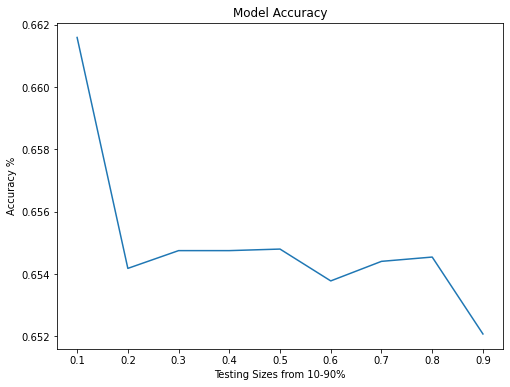

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Model Accuracy')
plt.xlabel('Testing Sizes from 10-90%')
plt.ylabel('Accuracy %')
plt.plot(test_acc, accuracy);

The accuracy of the model improves (by 0.8%) when we decrease the testing size to 10% from 20% of data. The model makes marginal improvements from 40% to 70% of training size. In general, the larger the training data, the stronger are the predictions. This is most evident at 90% training and 10% testing data. 


## **Part 2: Predicting if a runner is male/female using finish times and age**

An additional feature to include in our model to improve predictions is the variable `Age`. For this, we can compute a two-dimensional KDE to find the probability a runner is female given their time and age. The new Bayes formula here is: 


$ P($female | time, age$) = \frac{P(time, age | female)*P(female)}{P(time, age | female)*P(female) + P(time, age | male)*P(male)}$ 


In [ ]:
# we repeat the last section, but add the variable age to compute conditional probabilty for KDEs
test_ac2 = np.linspace(0, 1, 11)[1:-1]
accuracy2 = [] #stores % of matches

for m in range(len(test_ac2)):
  train_df, test_df = train_test_split(df, test_size=test_ac2[m], random_state=123) 

  dfm = train_df[train_df["M/F"] == 'M']
  dff = train_df[train_df["M/F"] == 'F']

  kdem = gaussian_kde(dfm[['tot_minutes', 'Age']].T)
  kdef = gaussian_kde(dff[['tot_minutes', 'Age']].T)

  def p_f2(time, age): #probability is dependent on time and age
    pm = len(dfm)/len(train_df)
    pf = len(dff)/len(train_df)
    pf_given_min_age = (kdef([time, age])*pf)/(kdef([time, age])*pf + kdem([time, age])*pm) 
    return pf_given_min_age

  test_df.loc[:, 'prob_'+str((m+1)/10)] = p_f2(test_df['tot_minutes'], test_df['Age']) 
  test_probs = list(test_df[ 'prob_'+str((m+1)/10)]) 
  mf_pred = [] 
  for n in test_probs: 
    if n > 0.5:
      mf_pred.append('F')
    else:
      mf_pred.append('M')

  test_df.loc[:,'pred_'+str((m+1)/10)] = mf_pred
  accuracy2.append(sum(test_df['pred_'+str((m+1)/10)] == test_df['M/F'])/len(test_df))

We can plot the accuracy of this as well:

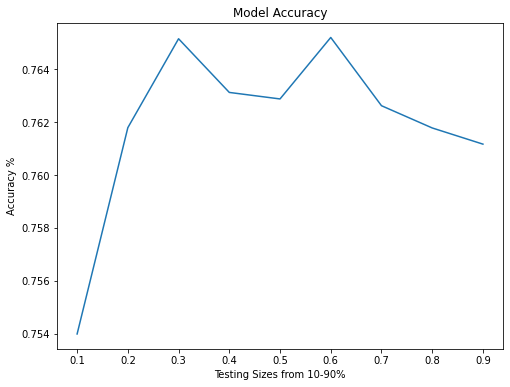

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Model Accuracy')
plt.xlabel('Testing Sizes from 10-90%')
plt.ylabel('Accuracy %')
plt.plot(test_ac2, accuracy2);

It's clear to see that age improves our model's accuracy by 10% on average compared to the last one. While there is an overall improvement when we include age, the model is more accurate for a training to testing ratio of 70% to 30%. Increasing testing data beyond this does not make a big difference (the accuracy ranges from 76.4% to 76.1%). 

Now, we can compare both of these predictions to the k-NN predictor. 

## **Part 3: Comparing accuracy of predictions to k-NN predictions**

Another thing we can do is compare our model to the build in k-NN predictor of the `sklearns` library. This can help us see which is a more accurate model. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

def plot_knn(k):

  ktest_acc = np.linspace(0, 1, 11)[1:-1]
  kaccuracy1 = [] #accuracy for 1 dim (time)
  kaccuracy2 = [] #accuracy for 2 dim (time, age)

  for m in range(len(ktest_acc)):
    
    train_df, test_df = train_test_split(df, test_size=ktest_acc[m], random_state=123)

  ### finding k-NN pred for time

    neigh1 = KNeighborsClassifier(n_neighbors=k)
    neigh1.fit(train_df[['tot_minutes']], train_df['M/F'])
    knn_pred1  = neigh1.predict(test_df[['tot_minutes']])

  ### finding k-NN pred for time and age
    neigh2 = KNeighborsClassifier(n_neighbors=k)
    neigh2.fit(train_df[['tot_minutes', 'Age']], train_df['M/F'])
    knn_pred2  = neigh2.predict(test_df[['tot_minutes', 'Age']])

    kaccuracy1.append((knn_pred1 == test_df['M/F']).sum()/len(test_df))
    kaccuracy2.append((knn_pred2 == test_df['M/F']).sum()/len(test_df))

  ### plotting and comparing accuracies
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,9)) #set figure axis

  ax1.set_title('Model comparisions (Bayes vs k-NN) for 1-dim KDE, time')
  ax1.plot(test_acc, accuracy, '--', label= 'Bayes')
  ax1.plot(test_acc, kaccuracy1, '-r', label='K-NN')
  ax1.set_ylabel('Accuracy')
  ax1.legend() #display legend

  ax2.set_title('Model comparisions (Bayes vs k-NN) for 2-dim KDE, time and age')
  ax2.plot(test_acc, accuracy2, '--', label= 'Bayes')
  ax2.plot(test_acc, kaccuracy2, '-r',  label= 'K-NN')
  ax2.set_xlabel('TestSize')
  ax2.set_ylabel('Accuracy')
  ax1.legend();

The two lists, `kaccuracy1` and `kaccuracy2` contain accuracy percentages of the k-NN predictor. We can compare these two lists to `accuracy` and `accuracy1` respectively to see how well our models fares to this. Below, I plot the comparisons to compare accuracy levels. You can move `k` to see how increasing or decreasing the number of nearest neighbors influences model predictions. 

In [ ]:
interact(plot_knn, k=(10, 100, 1), show_kernels=True);

interactive(children=(IntSlider(value=55, description='k', min=10), Output()), _dom_classes=('widget-interact'…

Overall, our model is much more successful at predicting the labels of the test data than the k-NN predictor. This is much more evident in the model that uses a single predictor as opposed to the second model that uses both, time and age. For small and large values of `k` the two models grow further apart, with the K-NN predictor returning smaller accuracy levels.

## **Part 4: Using linear regression to predict finish times of runners**

Let's first use 90% training and 10% testing data (which was the optimal based on our previous model) to regress total minutes on 5K time. Using this we can build on the regression equation to see how accurately we can predict finishing times.

In [ ]:
df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,129.283333
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,129.800000
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,130.366667
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,130.783333
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,130.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,64,F,USA,00:50:15,01:43:31,02:36:53,03:32:26,03:43:46,04:25:53,05:19:44,06:17:19,07:13:34,07:38:56,00:17:31,26594,12015,269,458.933333
26294,61,F,USA,00:48:36,01:39:39,02:39:13,03:35:58,03:47:55,04:32:44,05:31:58,06:28:56,07:26:19,07:51:30,00:17:59,26595,12016,270,471.500000
26295,66,F,USA,00:53:03,01:47:16,02:41:45,03:37:07,03:48:21,04:33:51,05:38:56,06:38:51,07:36:18,07:59:33,00:18:18,26596,12017,91,479.550000
26296,53,M,USA,00:49:04,01:40:12,02:33:31,03:31:41,03:43:35,04:29:20,05:31:11,06:33:35,07:35:38,08:00:37,00:18:20,26597,14580,2055,480.616667


We first need to convert the 5K times into minutes.

In [ ]:
import datetime as dt

df['5k_s'] = pd.to_timedelta(df["5K"]).dt.total_seconds()/60 #in minutes
df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_s
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,129.283333,14.716667
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,129.800000,14.716667
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,130.366667,14.716667
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,130.783333,14.716667
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,130.816667,14.716667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,64,F,USA,00:50:15,01:43:31,02:36:53,03:32:26,03:43:46,04:25:53,05:19:44,06:17:19,07:13:34,07:38:56,00:17:31,26594,12015,269,458.933333,50.250000
26294,61,F,USA,00:48:36,01:39:39,02:39:13,03:35:58,03:47:55,04:32:44,05:31:58,06:28:56,07:26:19,07:51:30,00:17:59,26595,12016,270,471.500000,48.600000
26295,66,F,USA,00:53:03,01:47:16,02:41:45,03:37:07,03:48:21,04:33:51,05:38:56,06:38:51,07:36:18,07:59:33,00:18:18,26596,12017,91,479.550000,53.050000
26296,53,M,USA,00:49:04,01:40:12,02:33:31,03:31:41,03:43:35,04:29:20,05:31:11,06:33:35,07:35:38,08:00:37,00:18:20,26597,14580,2055,480.616667,49.066667


Now we can regress `tot_minutes` on `5k_s` to check the fit.

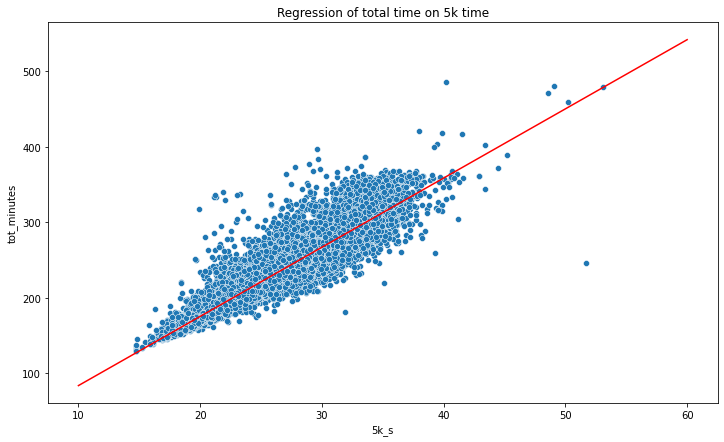

In [ ]:
from sklearn.linear_model import LinearRegression #import modules
import seaborn as sns 

train_df, test_df = train_test_split(df, test_size=0.1, random_state=123) #split into 90% training and 10% testing data

reg = LinearRegression()
reg.fit(train_df[['5k_s']], train_df['tot_minutes']) #fitting

#plotting the regression
plt.figure(figsize=(12, 7))
plt.title('Regression of total time on 5k time')
sns.scatterplot(data=train_df, x='5k_s', y='tot_minutes', marker='o')
x = np.linspace(10, 60, 100)
plt.plot(x, reg.coef_[0]*x + reg.intercept_, c='r');

Based on the plot, there is a positive relationship between 5K minute timing and finishing timings. We can further analyze how far off the model's predictions are to the actual finishing times of the runners. 

In [ ]:
test_df['regression'] = reg.predict(test_df[['tot_minutes']])
test_df

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- tot_minutes
Feature names seen at fit time, yet now missing:
- 5k_s

  warnings.warn(message, FutureWarning)


,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_s,regression
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,03:08:26,03:36:40,03:48:56,00:08:44,16054,5886,682,228.933333,27.516667,2090.931703
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,02:20:18,02:42:10,02:51:28,00:06:33,1085,1039,870,171.466667,18.500000,1564.059111
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,02:13:14,02:33:04,02:42:01,00:06:11,359,343,21,162.016667,18.516667,1477.418520
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,02:34:10,03:00:20,03:12:22,00:07:21,5149,515,449,192.366667,20.316667,1755.676927
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,03:11:08,03:37:51,03:49:11,00:08:45,16128,5935,1083,229.183333,25.033333,2093.223782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6049,41,M,USA,00:22:03,00:45:03,01:07:50,01:30:45,01:35:47,01:53:49,02:17:21,02:42:02,03:05:57,03:16:15,00:07:30,6064,5299,1039,196.250000,22.050000,1791.280557
13598,42,M,USA,00:24:57,00:49:46,01:14:40,01:40:11,01:45:46,02:05:45,02:32:12,02:59:57,03:28:03,03:40:43,00:08:26,13662,9252,1539,220.716667,24.950000,2015.598702
23995,47,F,USA,00:33:33,01:06:34,01:39:51,02:13:38,02:21:00,02:47:48,03:24:10,03:59:12,04:31:47,04:46:16,00:10:56,24224,10663,1692,286.266667,33.550000,2616.581853
14516,38,F,USA,00:26:14,00:51:29,01:16:46,01:42:19,01:47:55,02:08:49,02:36:20,03:04:36,03:32:11,03:43:49,00:08:33,14591,4971,3364,223.816667,26.233333,2044.020483


We can see extremely large deviations in regression times that our model is predicting. We can also decribe it down below:

In [ ]:
test_df['regression_error'] = test_df['regression'] - test_df['tot_minutes']
np.abs(test_df['regression_error']).describe()

count    2630.000000
mean     1840.493853
std       326.376768
min      1083.149385
25%      1611.503328
50%      1781.063966
75%      2001.234133
max      2975.067640
Name: regression_error, dtype: float64

We can also plot boxplots to see variance: 

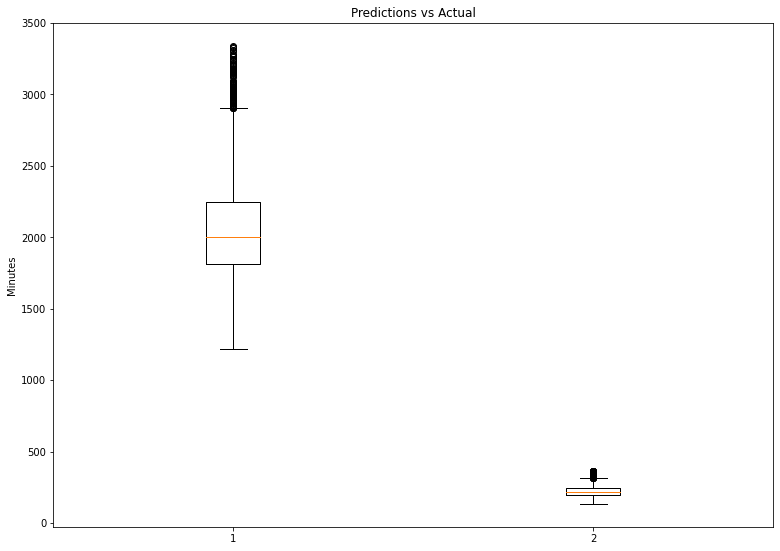

In [ ]:
data_1 = test_df['regression']
data_2 = test_df['tot_minutes']
data = [data_1, data_2]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.title('Predictions vs Actual')
plt.ylabel('Minutes')
plt.show();

The boxplots show just how spread out the data is. While the regression predictions are more spread out, they are much higher than the actual finishing times of the test data. We can check the overall accuracy of the model using $R^2$: 

In [ ]:
reg.score(test_df[['5k_s']], test_df['tot_minutes'])

0.8423992349177898

While the R score is high, there is a huge variation in our predictions and actual timings. Thus, we need to control for other factors and check for the R-sq. 

Now, we can incorporate other factors such as gender and age into the model to see how these factors influence predictions. 

In [ ]:
reg2 = LinearRegression()
train_df = pd.concat([train_df, pd.get_dummies(train_df['M/F'])], axis=1)
reg2.fit(train_df[['5k_s', 'M', 'F', 'Age']], train_df['tot_minutes'])
train_df['regression_2'] = reg2.predict(train_df[['5k_s', 'M', 'F', 'Age']])
train_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,Finish,Pace,Overall,Gender,Division,tot_minutes,5k_s,F,M,regression_2
16226,61,M,USA,00:26:32,00:53:11,01:19:16,01:48:22,01:54:23,02:15:35,02:42:45,...,03:49:58,00:08:47,16327,10275,289,229.966667,26.533333,0,1,238.432130
11359,58,M,USA,00:25:03,00:50:23,01:15:19,01:40:15,01:45:28,02:05:29,02:31:16,...,03:33:54,00:08:10,11403,8297,459,213.900000,25.050000,0,1,224.454940
19600,41,F,USA,00:30:32,00:59:16,01:27:54,01:57:04,02:03:13,02:26:06,02:55:00,...,04:05:06,00:09:21,19747,8097,1483,245.100000,30.533333,1,0,271.328990
19169,37,F,CAN,00:27:54,00:55:18,01:22:59,01:51:01,01:57:17,02:19:56,02:49:47,...,04:02:25,00:09:15,19309,7832,4298,242.416667,27.900000,1,0,246.755561
1508,44,M,USA,00:19:45,00:39:34,00:59:30,01:19:22,01:23:46,01:39:38,02:01:08,...,02:54:39,00:06:40,1511,1436,180,174.650000,19.750000,0,1,173.920053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15377,26,F,USA,00:25:18,00:51:06,01:16:33,01:41:52,01:47:26,02:08:08,02:35:55,...,03:46:50,00:08:40,15463,5505,3578,226.833333,25.300000,1,0,221.216860
21602,60,F,CAN,00:31:03,01:01:33,01:30:58,02:00:14,02:06:34,02:30:29,03:02:19,...,04:19:26,00:09:54,21787,9327,114,259.433333,31.050000,1,0,279.447734
17730,43,F,USA,00:27:06,00:53:30,01:20:51,01:48:06,01:54:00,02:16:06,02:44:59,...,03:55:26,00:08:59,17852,6994,1297,235.433333,27.100000,1,0,240.596334
15725,47,F,USA,00:27:22,00:53:47,01:19:38,01:47:14,01:53:03,02:13:46,02:41:02,...,03:48:11,00:08:43,15818,5737,649,228.183333,27.366667,1,0,243.735550


We can create dummy variables for M/F for the test data and add the regression column now. 

In [ ]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['M/F'])], axis=1)
test_df['regression_2'] = reg2.predict(test_df[['5k_s', 'M', 'F', 'Age']])
test_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,Overall,Gender,Division,tot_minutes,5k_s,regression,regression_error,F,M,regression_2
15955,47,F,USA,00:27:31,00:53:43,01:19:39,01:45:57,01:51:39,02:12:27,02:40:08,...,16054,5886,682,228.933333,27.516667,2090.931703,1861.998370,1,0,245.094057
1083,37,M,NED,00:18:30,00:37:13,00:56:19,01:15:54,01:20:10,01:35:53,01:57:06,...,1085,1039,870,171.466667,18.500000,1564.059111,1392.592444,0,1,161.332002
358,40,M,CAN,00:18:31,00:37:16,00:56:05,01:15:04,01:19:12,01:34:06,01:53:31,...,359,343,21,162.016667,18.516667,1477.418520,1315.401853,0,1,162.026018
5136,34,F,USA,00:20:19,00:41:00,01:01:57,01:23:14,01:27:55,01:44:44,02:07:58,...,5149,515,449,192.366667,20.316667,1755.676927,1563.310261,1,0,177.532444
16029,40,F,CAN,00:25:02,00:51:08,01:19:07,01:45:56,01:51:43,02:13:12,02:41:19,...,16128,5935,1083,229.183333,25.033333,2093.223782,1864.040449,1,0,221.336064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6049,41,M,USA,00:22:03,00:45:03,01:07:50,01:30:45,01:35:47,01:53:49,02:17:21,...,6064,5299,1039,196.250000,22.050000,1791.280557,1595.030557,0,1,194.207415
13598,42,M,USA,00:24:57,00:49:46,01:14:40,01:40:11,01:45:46,02:05:45,02:32:12,...,13662,9252,1539,220.716667,24.950000,2015.598702,1794.882035,0,1,220.652895
23995,47,F,USA,00:33:33,01:06:34,01:39:51,02:13:38,02:21:00,02:47:48,03:24:10,...,24224,10663,1692,286.266667,33.550000,2616.581853,2330.315186,1,0,299.736204
14516,38,F,USA,00:26:14,00:51:29,01:16:46,01:42:19,01:47:55,02:08:49,02:36:20,...,14591,4971,3364,223.816667,26.233333,2044.020483,1820.203817,1,0,231.842069


There is a huge difference in this model's predictions. We can confirm this by plotting the boxplots again:

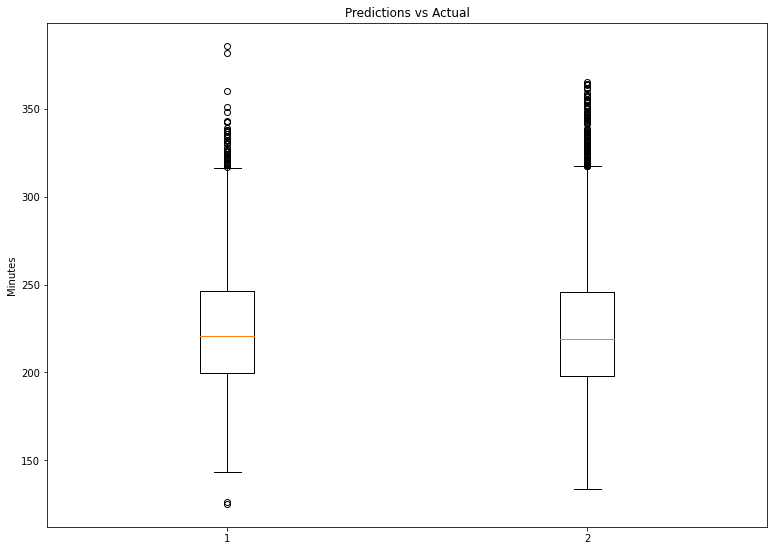

In [ ]:
data_1 = test_df['regression_2']
data_2 = test_df['tot_minutes']
data = [data_1, data_2]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.title('Predictions vs Actual')
plt.ylabel('Minutes')
plt.show();

There is huge improvement in the model's ability to predict finishing times when we control for age and gender. The $R^2$ for this model is given as: 

In [ ]:
reg2.score(test_df[['5k_s', 'M', 'F', 'Age']], test_df['tot_minutes'])

0.843865529049102

Thus, 84.3 % of the variation in `tot_minutes` can be explained by our model's predictors.

Additionally, the mean for the regression error for both our models (the one that controls for additional factors and the one that doesn't) is as follows:

In [ ]:
test_df['regression_error2'] = test_df['regression_2'] - test_df['tot_minutes'] 
print(test_df['regression_error'].mean(), test_df['regression_error2'].mean())

1840.4938528524945 -0.10993669157064999


This shows how much better our second model is at predicting the finishing times.

## **Conclusion**

In conclusion, we looked at how the Bayes Theorem can be used to predict the probability a runner is female based on first, their finishing time and second, both their time and age. We saw how we can use KDE's to compute conditional probabilities and the influence of both bandwidth and training data size on variance.

We also built regression models to predict how controlling for factors like Age and Gender can have a huge influence on the $\hat{\beta}$ estimate. 